# Capillary Viscometry Analysis
    
    @author Daniel Duke <daniel.duke@monash.edu>
    @copyright (c) 2025 Monash Univ.
    @license GPL-3.0+
    @version 0.0.1
    @date 23/06/2025

    Multiphase Flow Laboratory
    Monash University, Australia




In [2]:
import matplotlib.pyplot as plt
import numpy as np
import h5py, os, glob
%matplotlib widget

## Load and plot the data

In [16]:
data={}

for file_name in glob.glob('/Users/dduke/Desktop/cap/ctrl*.h5'):

    H=h5py.File(file_name,'r')
    for cap in H.keys():
        data[cap] = H[cap][...]
        print(file_name, '\t', cap)
    H.close()
    

caps = list(data.keys())

/Users/dduke/Desktop/cap/ctrl2.h5 	 capillary_75
/Users/dduke/Desktop/cap/ctrl34.h5 	 capillary_112
/Users/dduke/Desktop/cap/ctrl34.h5 	 capillary_150
/Users/dduke/Desktop/cap/ctrl5.h5 	 capillary_187
/Users/dduke/Desktop/cap/ctrl1.h5 	 capillary_37


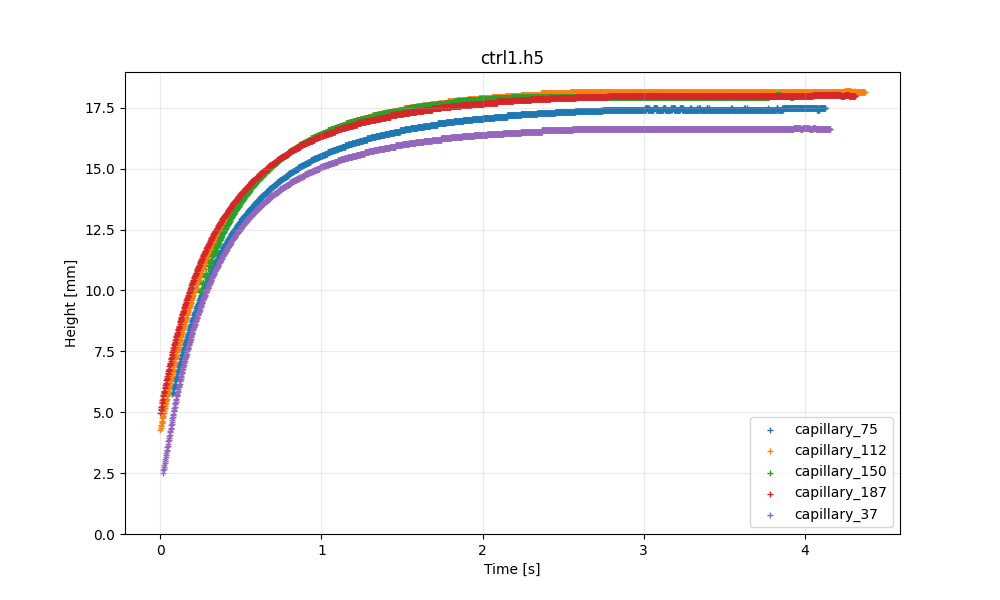

In [17]:
fig=plt.figure(figsize=(10,6))
ax=fig.add_subplot(111)
plt.grid(alpha=.25,which='major')
plt.grid(alpha=.25,which='minor',axis='x')
#plt.xlim(.9,8)
#plt.xscale('log')
plt.title(os.path.basename(file_name));
plt.xlabel("Time [s]")
plt.ylabel("Height [mm]")

for c in caps:
    
    time = data[c][0,:]; height = data[c][1,:]

    # Remove data points followed by a large number of NaN
    for i in range(len(time)):
        n_nan = np.sum(np.isnan(height[i:i+50]))
        if n_nan>=35: height[i]=np.nan

    # Remove data point with too large change
    flt = ~np.isnan(height)
    j = np.where(flt)[0]
    delta = np.abs(np.diff(height[flt]))
    delta = np.hstack((0,delta))
    for i in range(len(delta)):
        if delta[i] > 0.1:
            height[j[i]:j[i]+2]=np.nan
    
    # Shift start of curve to t=0
    time -= time[np.where(height==np.nanmin(height))[0][0]]

    # Filter data by time or height
    flt = (height<2.5) | (time<0)
    
    time[flt]=np.nan
    height[flt]=np.nan
    
    
    ax.scatter(time, height, lw=1, s=15, marker='+', label=c)

plt.ylim(0,)
ax.legend();


## Estimate the initial velocity

1.1228915970545819
1.2382279285432354
0.9445499883497177
1.2391917550352527
1.486596619927329


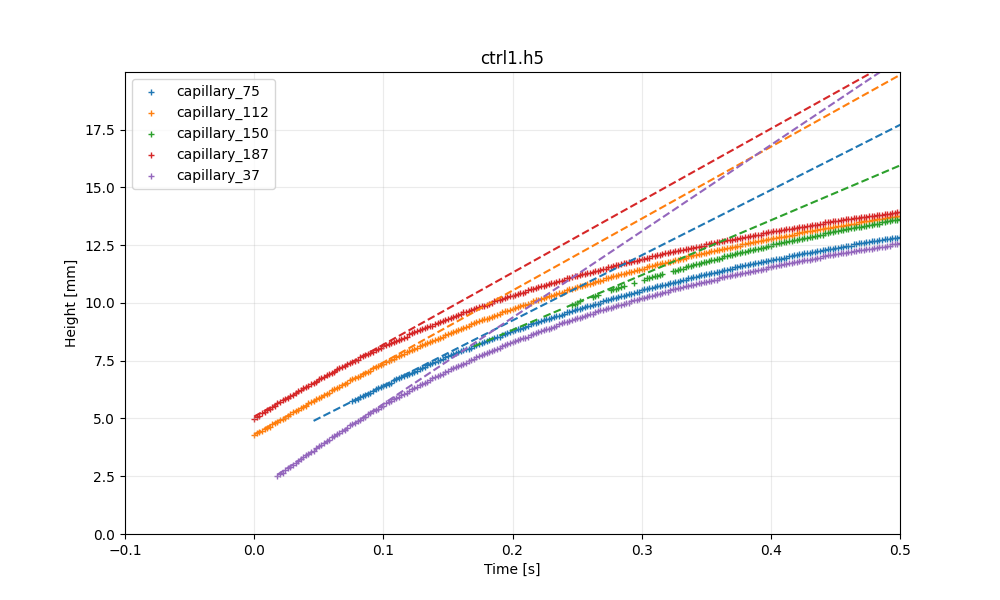

In [79]:
from scipy.optimize import curve_fit

myfun = lambda t,a,b: a*t + b

fig=plt.figure(figsize=(10,6))
ax=fig.add_subplot(111)
plt.grid(alpha=.25)
plt.title(os.path.basename(file_name));
plt.xlabel("Time [s]")
plt.ylabel("Height [mm]")

initial_velocity_estimate={}

for c in caps:
    
    time = data[c][0,:]; height = data[c][1,:]

    tmin = np.nanmin(time[~np.isnan(height)]) + 0.01
    if tmin < 0.1: tmin=0.1
    
    flt = ~np.isnan(height) & (time > 0) & (time < tmin) # first fraction sec 
    
    popt,pcov=curve_fit(myfun,time[flt],height[flt],p0=[1,0])
    
    ax.scatter(time, height, lw=1, s=15, marker='+', label=c)

    plt.plot(time, myfun(time, *popt), ls='--')

    initial_velocity_estimate[c] = popt # 'a' parameter of my function, in mm/s
    print(initial_velocity_estimate[c][0]/(8*np.pi))
    
plt.ylim(0,np.nanmax(height)*1.2)
plt.xlim(-0.1,0.5)
ax.legend();


## Fit functions to the data

### The Lucas-Washburn-Rideal equation

$ \rho \pi r^2 \left( h h' \right)' = 2\pi  r \sigma \cos \theta - \pi r^2 \rho g h - 8 \pi \mu h h' $

Lumping constants, if $\theta$ is assumed constant:

$ a  \left( h h' \right)' = b - a g h - f h h'$

Apply product rule:

$ a h h'' + a h'^2  = b - a g h - f h h' = 0$

$ h'' = - \frac{h'^2}{h}  + \frac{b}{ah} - g - \frac{f h'}{a}$

Only 3 unknowns in a second-order nonlinear ODE.  $a$, $b$ depend on the geometry and $\theta$, only $f$ depends on the viscosity. The region we care most about is the early-time period where the $d$ term dominates, as $h'$ is large, but the $c$ term is small, as $h$ is small.

In [80]:
# Estimates for the constants

RHO = 1000. # kg/m3
SIGMA = 0.072 # N/m
THETA = 0 * np.pi/180. # rad
VISC = 1e-3 # Pa.s
GRAVITY = 9.81 # N/kg

R={}
for c in caps:
    R[c] = 0.0005239 # [m] 50µL cap
    if c == 'capillary_187': R[c] = 0.00031535 # [m] 20µL cap

If the velocity is constant in the limit $t \to 0$ with $h \approx vt + h_0$, then 

$ \frac{f h'}{a} \approx - \frac{h'^2}{h}  + \frac{b}{ah} - g $

$  f \approx - \frac{a h'}{h}  + \frac{b}{h h'} - \frac{a g}{h'} $

$  f \approx - \frac{ a v }{ h_0 } + \frac{b}{v h_0 } - \frac{ a g }{v } $

30.618297425385947
22.81072531053376
37.683509970497894
14.727291917359985
24.49125227731342


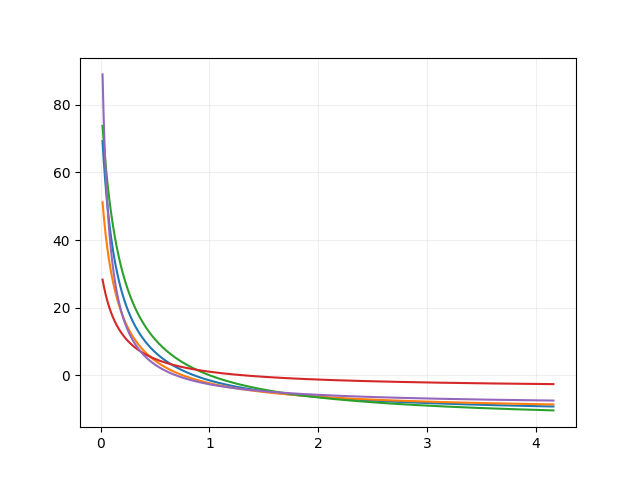

In [81]:
fig=plt.figure()
plt.grid(alpha=.2)

for c in caps:

    a = RHO * np.pi * R[c]**2
    b = 2*np.pi*R[c]*SIGMA*np.cos(THETA)
    
    h0 = initial_velocity_estimate[c][1] * 1e-3
    v0 = initial_velocity_estimate[c][0] * 1e-3
    
    h = h0+v0*.15
    f = (-a*v0/h) + (b/(v0*h)) - (a*GRAVITY)/v0
    print(1e3*f/(8*np.pi))
    
    plt.plot(time[time>0], ((-a*v0/(h0+v0*time[time>0])) + (b/(v0*(h0+v0*time[time>0]))) - (a*GRAVITY)/v0)*1e3/(8*np.pi))

#plt.ylim(-10,100);
#plt.xlim(0,.2);

## Attempt to fit the full LWR equation

In [82]:
import lmfit
from lmfit import Parameters, minimize, report_fit
from scipy.integrate import odeint

In [83]:
def lwr_system(y, t, params):
    # Unpack parameters from lmfit.Parameters object
    r_ = params['r'].value
    rho_ = params['rho'].value
    sigmat_ = params['sigmat'].value
    visc_ = params['visc'].value
    h0_ = params['h0'].value

    a = rho_ * np.pi * r_**2
    b = 2*np.pi*r_*sigmat_
    f = 8*np.pi*visc_
    
    # y = [ h h' ] ; y' = [ h' h'' ]
    # Define the differential equations
    dydt = [  y[1], 
            (-y[1]**2/(y[0]-h0_))+(b/(a*(y[0]-h0_)))-GRAVITY-(f*y[1])/a ]
    
    return dydt

def simulate_ode(t, initial_conditions, params):
    solution = odeint(lwr_system, initial_conditions, t, args=(params,))
    return solution

def residual(params, t, data, initial_conditions):
    model = simulate_ode(t, initial_conditions, params)
    res = (model - data)
    res[:,1]=0#res[:,0] # do not check residuals on velocity, only height
    return res.ravel()  # Flatten for lmfit

In [90]:
results = {}
for c in caps:

    params = Parameters()
    params.add('r',     value=R[c],                   min=R[c]*0.9, max=R[c]*1.1)
    params.add('rho',   value=RHO,                 min=RHO*0.9, max=RHO*1.1)
    params.add('sigmat',value=SIGMA*np.cos(THETA), min=SIGMA*0.9, max=SIGMA*1.1)
    params.add('h0',    value=0,                   min=-1e-1, max=1e-1)
    params.add('visc',  value=VISC,                min=0.1*VISC, max=100*VISC)

    # use non-NaN data, require time>0
    flt = ~np.isnan(data[c][1,:]) & (data[c][0,:]>=0) 
    # use early time data
    flt = flt & (data[c][0,:] < 20.0 )
    
    model_time = data[c][0,flt] # seconds
    height = data[c][1,flt] * 1e-3 # convert to m
    initial_dhdt = initial_velocity_estimate[c][0] * 1e-3 # convert to m/s
    initial_h = height[0] * 1e-3 # convert to  m #initial_velocity_estimate[c][1] * 1e-3 # convert to  m
    
    initial_conditions=[initial_h, initial_dhdt]
    
    
    expt_data=np.vstack((height,height)).transpose()

    results[c] = minimize(residual, params, args=(model_time, expt_data, initial_conditions), method='leastsq')
    
    print("---- %s ----" % c)
    print(initial_conditions)
    
    #report_fit(results[c])

    print("h0=%g mm" % (1e3*results[c].params['h0'].value))
    print("RHO =%g kg/m3" % (results[c].params['rho'].value))
    print("R   =%g um" % (results[c].params['r'].value*1e6))
    print("SIGMA.cos(THETA)=%g mN/m" % (1e3*results[c].params['sigmat'].value ))
    print("VISC=%g mPa.s" % (1e3*results[c].params['visc'].value))

---- capillary_75 ----
[np.float64(5.744869565217392e-06), np.float64(0.028221343936675077)]
h0=-3.56002 mm
RHO =1099.11 kg/m3
R   =574.828 um
SIGMA.cos(THETA)=64.8549 mN/m
VISC=11.7766 mPa.s
---- capillary_112 ----
[np.float64(4.27304347826087e-06), np.float64(0.031120062110249088)]
h0=-0.305044 mm
RHO =1099.99 kg/m3
R   =576.289 um
SIGMA.cos(THETA)=64.8001 mN/m
VISC=33.9039 mPa.s
---- capillary_150 ----
[np.float64(9.922956521739132e-06), np.float64(0.02373913043478238)]
h0=-3.04913 mm
RHO =1100 kg/m3
R   =576.286 um
SIGMA.cos(THETA)=64.8002 mN/m
VISC=6.76482 mPa.s
---- capillary_187 ----
[np.float64(4.9852173913043485e-06), np.float64(0.031144285712062344)]
h0=-16.8234 mm
RHO =1100 kg/m3
R   =346.885 um
SIGMA.cos(THETA)=64.8 mN/m
VISC=1.93386 mPa.s
---- capillary_37 ----
[np.float64(2.516347826086957e-06), np.float64(0.037362248160120924)]
h0=-4.17608 mm
RHO =1100 kg/m3
R   =576.29 um
SIGMA.cos(THETA)=64.8001 mN/m
VISC=13.0473 mPa.s


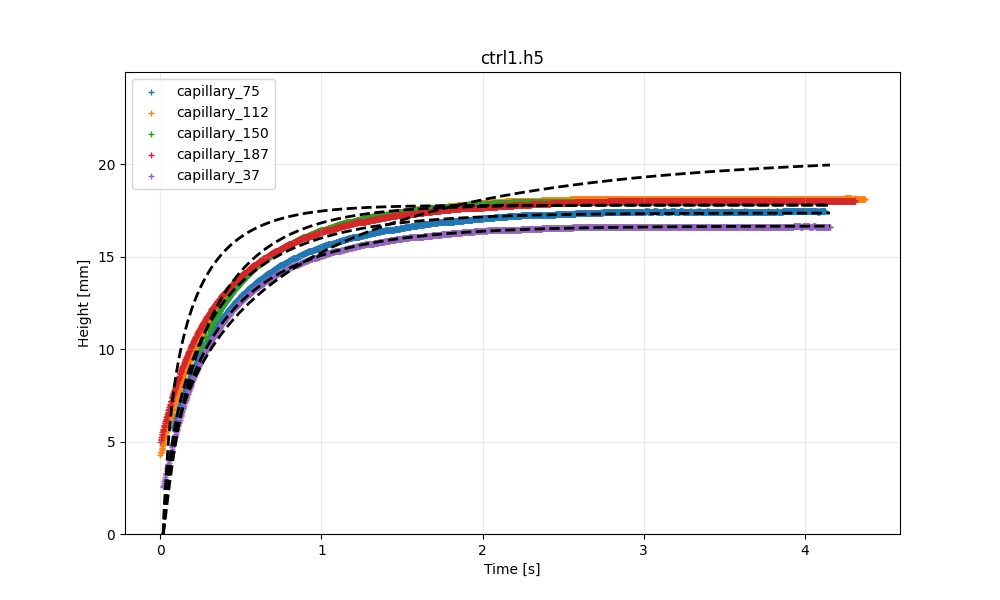

In [91]:
plt.close()
fig=plt.figure(figsize=(10,6))

ax=fig.add_subplot(111)
plt.grid(alpha=.25,which='major')
plt.grid(alpha=.25,which='minor',axis='x')
#plt.xlim(-0.1,1.5)
#plt.yscale('log'); plt.ylim(1,20)
plt.title(os.path.basename(file_name));
plt.xlabel("Time [s]")
plt.ylabel("Height [mm]")

#ax2=ax.twinx()

for c in caps:
    time = data[c][0,:]
    ax.scatter(time, data[c][1,:], lw=1, s=15, marker='+', label=c)

    model = simulate_ode(model_time, initial_conditions, results[c].params)
    
    ax.plot(model_time, 1e3*model[:,0] , lw=2, c='k', ls='--') # back from m to mm


ax.legend();
plt.ylim(0, np.nanmax(data[c][1,:])*1.5);